In [1]:
import numpy as np 
import sigma
import librosa
from scipy.signal import butter, lfilter, freqz
from matplotlib import pyplot as plt 

import tensorflow as tf 
from tensorflow.keras import models, layers 

import os 
from tqdm import tqdm 

In [2]:
speech_path = "Dataset/Speech"
egg_path = "Dataset/EGG"
trim_size = 16384

model_path = "models/Checkpoint_150_150"

model = models.load_model(model_path)

In [3]:
def load_paths():

    speech = os.listdir(speech_path)
    egg = os.listdir(egg_path)
    names = [i for i in tqdm(speech, ascii = True, desc = "Loading Filepaths", ncols = 100) if i in egg]
    return names

def load_random_sample():
    names = load_paths()
    rand_idx = np.random.randint(0, len(names))
    input_signal = librosa.load(os.path.join(speech_path, names[rand_idx]))[0]
    target_signal = librosa.load(os.path.join(egg_path, names[rand_idx]))[0]
    l = len(input_signal)
    lim = l - trim_size
    low = np.random.randint(0, lim)
    high = low + trim_size 
    input_signal = input_signal[low:high]
    target_signal = target_signal[low:high]
    model_inp = np.expand_dims(input_signal, -1)
    model_targ = model.predict(np.expand_dims(model_inp, 0))[0]
    model_targ = model_targ.ravel()
    # print(model_targ.shape)
    # input_signal = np.expand_dims(input_signal, -1)
    # target_signal = np.expand_dims(target_signal, -1)
    return input_signal, target_signal, model_targ

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
    
def load_window_lengths():
    names = load_paths()
    rand_idx = np.random.randint(0, len(names))
    input_signal = librosa.load(os.path.join(speech_path, names[rand_idx]))[0]
    target_signal = librosa.load(os.path.join(egg_path, names[rand_idx]))[0]
    input_windows = []
    target_windows = []
    predicted_windows = []
    window_size = 16384
    l = len(input_signal)
    n = l//window_size 
    for i in range(n):
        isig = input_signal[i*window_size : (i+1)*window_size]
        tsig = target_signal[i*window_size : (i+1)*window_size]
        minp = np.expand_dims(isig, -1)
        psig = model.predict(np.expand_dims(minp, 0))[0]
        psig = psig.ravel()
        psig = butter_lowpass_filter(psig, 300, 16384, 6)
        input_windows.append(isig)
        target_windows.append(tsig)
        predicted_windows.append(psig)
    return input_windows, target_windows, predicted_windows

In [4]:
inp, targ, model_targ = load_random_sample()

gci_true, goi_true = sigma.get_glottal(targ, sr_egg = 16384)
gci_pred, goi_pred = sigma.get_glottal(model_targ, sr_egg = 16384)

Loading Filepaths: 100%|#####################################| 3377/3377 [00:00<00:00, 43049.03it/s]
/home/harish/Documents/Python Scripts/SAP Project/Glottal-Instants-Extraction/sigma.py:34: RuntimeWarning: invalid value encountered in true_divide
  group_delay = np.real(X_r/X)
/home/harish/Documents/Python Scripts/SAP Project/Glottal-Instants-Extraction/sigma.py:34: RuntimeWarning: invalid value encountered in true_divide
  group_delay = np.real(X_r/X)


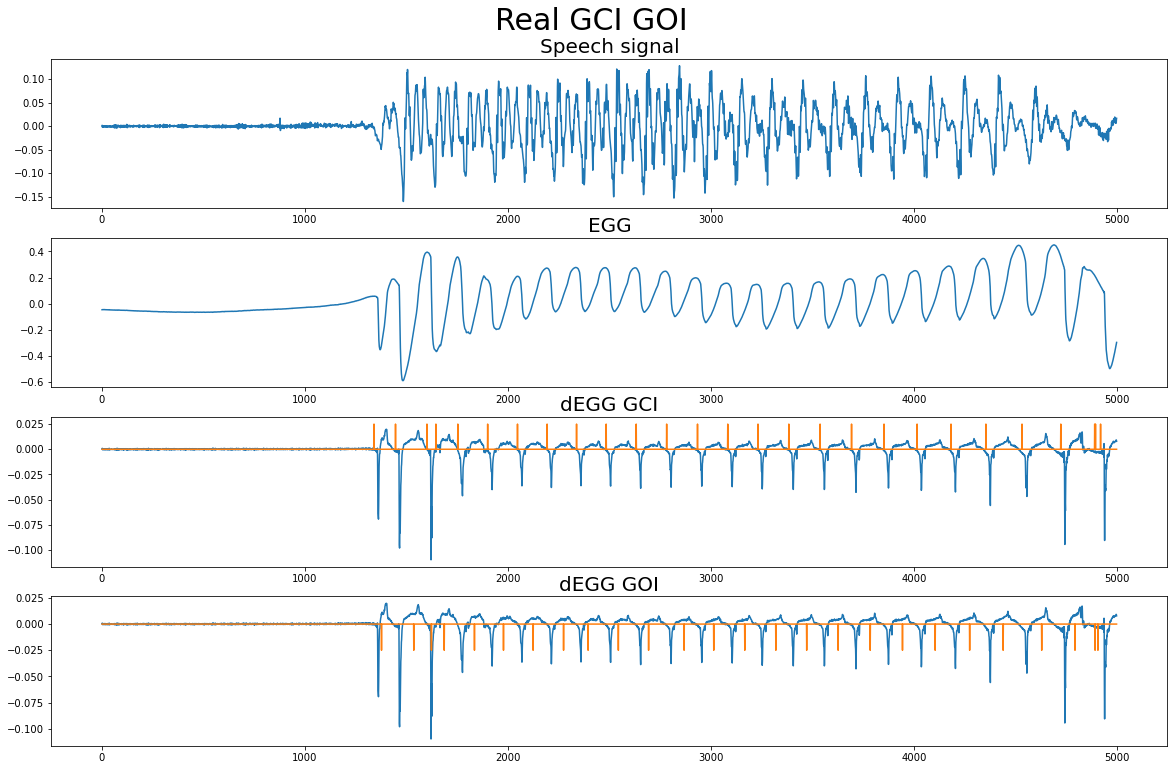

In [5]:
sigma.plot(targ, inp, gci_true, goi_true, trim = 5000, title = "Real GCI GOI")

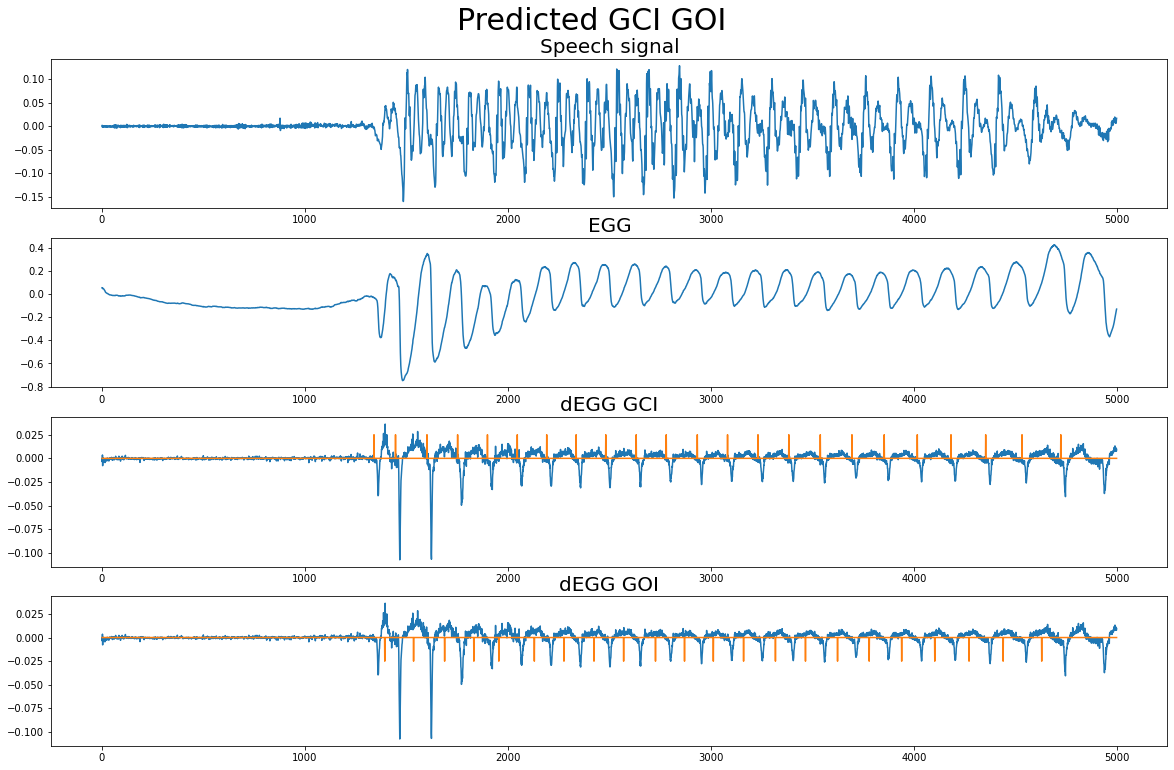

In [6]:
sigma.plot(model_targ, inp, gci_pred, goi_pred, trim = 5000, title = "Predicted GCI GOI")

In [7]:
def mean(x):
    return sum(x)/len(x)

In [8]:
ir_gci = []
mr_gci = []
far_gci = []
iar_gci = []

ir_goi = []
mr_goi = []
far_goi = []
iar_goi = []

for _ in range(50):

    print("Loading Sample {}".format(_ + 1))

    INPUT, TARGET, PREDICTED = load_window_lengths()

    GCI_TRUE = []
    GCI_PRED = []
    GOI_TRUE = []
    GOI_PRED = []
    for i in range(len(INPUT)):
        got, gct = sigma.get_glottal(TARGET[i], sr_egg = 16384)
        gof, gcf = sigma.get_glottal(PREDICTED[i], sr_egg = 16384)
        GCI_TRUE.append(np.array(gct))
        GOI_TRUE.append(np.array(got))
        GCI_PRED.append(np.array(gcf))
        GOI_PRED.append(np.array(gof))



    for i in range(len(GCI_TRUE)):
        m1 = max(max(GCI_TRUE[i]), max(GCI_PRED[i]))
        x = sigma.naylor_metrics(GCI_TRUE[i]/m1, GCI_PRED[i]/m1)
        ir_gci.append(x['identification_rate'])
        mr_gci.append(x['miss_rate'])
        far_gci.append(x['false_alarm_rate'])
        iar_gci.append(x['identification_accuracy'])
        m2 = max(max(GOI_TRUE[i]), max(GOI_PRED[i]))
        x = sigma.naylor_metrics(GOI_TRUE[i]/m2, GOI_PRED[i]/m2)
        ir_goi.append(x['identification_rate'])
        mr_goi.append(x['miss_rate'])
        far_goi.append(x['false_alarm_rate'])
        iar_goi.append(x['identification_accuracy'])



oject/Glottal-Instants-Extraction/sigma.py:34: RuntimeWarning: invalid value encountered in true_divide
  group_delay = np.real(X_r/X)
/home/harish/Documents/Python Scripts/SAP Project/Glottal-Instants-Extraction/sigma.py:34: RuntimeWarning: invalid value encountered in true_divide
  group_delay = np.real(X_r/X)
/home/harish/Documents/Python Scripts/SAP Project/Glottal-Instants-Extraction/sigma.py:34: RuntimeWarning: invalid value encountered in true_divide
  group_delay = np.real(X_r/X)
/home/harish/Documents/Python Scripts/SAP Project/Glottal-Instants-Extraction/sigma.py:34: RuntimeWarning: invalid value encountered in true_divide
  group_delay = np.real(X_r/X)
/home/harish/Documents/Python Scripts/SAP Project/Glottal-Instants-Extraction/sigma.py:34: RuntimeWarning: invalid value encountered in true_divide
  group_delay = np.real(X_r/X)
/home/harish/Documents/Python Scripts/SAP Project/Glottal-Instants-Extraction/sigma.py:34: RuntimeWarning: invalid value encountered in true_divide
 

In [9]:
print("GCI")
print("Mean Identification Rate: ", mean(ir_gci))
print("Mean Miss Rate: ", mean(mr_gci))
print("Mean False Alarm Rate: ", mean(far_gci))
print("Mean Identification Accuracy: ", mean(iar_gci))
print()
print()
print("GOI")
print("Mean Identification Rate: ", mean(ir_goi))
print("Mean Miss Rate: ", mean(mr_goi))
print("Mean False Alarm Rate: ", mean(far_goi))
print("Mean Identification Accuracy: ", mean(iar_goi))

GCI
Mean Identification Rate:  0.8997121896083139
Mean Miss Rate:  0.08657964586237314
Mean False Alarm Rate:  0.013708164529313059
Mean Identification Accuracy:  0.0013112047335952


GOI
Mean Identification Rate:  0.9297010080660523
Mean Miss Rate:  0.06417675741469865
Mean False Alarm Rate:  0.006122234519248828
Mean Identification Accuracy:  0.00025137985895548083
